In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from datetime import datetime
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from statsmodels.graphics import tsaplots
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import (RandomizedSearchCV,
                                    TimeSeriesSplit)

from sklearn.metrics import mean_squared_error, make_scorer


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Описание проекта "Прогнозирование хешрейта сети Bitcoin"

- Данный проект является частью финансовой модели по созданию майнинговой фермы биткойна. 
- Для определения теоретической доли награды фермы, в финансовой модели взята предпоссылка, что награда равняется доли производительности фермы от производительности сети.
- Учитывая, что производительность сети исторически постоянно увеличивается, необходимо спрогнозировать производительность сети для отражения снижения доли фермы на горизонте прогноза
- Источник данных в формате json взят отсюда: https://www.blockchain.com/ru/explorer/charts/hash-rate

# Загрузка и подготовка данных

In [4]:
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

In [5]:
# Чтение данных из файла JSON
with open('hash-rate.json', 'r') as file:
    data = json.load(file)

# Преобразование данных
hash_rate_data = [(datetime.fromtimestamp(item['x'] / 1000), item['y']) for item in data['hash-rate']]

# Создание DataFrame
data = pd.DataFrame(hash_rate_data, columns=['Date', 'Hash_Rate'])
data.set_index('Date', inplace=True)

In [6]:
#Вывод основной информации о датафрейме
def data_exploration(dataframe):
    print('\033[0m')
    print('\033[1m' + 'Информация о датафрейме:')
    print('\033[0m')
    dataframe.info()
    print('\033[0m')
    print('\033[1m' + 'Первые пять строк:')
    print('\033[0m')
    display(dataframe.head(10))

In [7]:
data_exploration(data)


Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2009-01-10 03:00:00 to 2024-10-22 03:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Hash_Rate  1442 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB

Первые пять строк:



,Hash_Rate
Date,
2009-01-10 03:00:00,1.065220e-07
2009-01-14 03:00:00,2.521021e-06
2009-01-18 03:00:00,5.588855e-06
2009-01-22 03:00:00,5.681174e-06
2009-01-26 03:00:00,6.270595e-06
2009-01-30 03:00:00,6.419726e-06
2009-02-03 03:00:00,5.830304e-06
2009-02-07 03:00:00,6.256393e-06
2009-02-11 03:00:00,6.306103e-06


In [8]:
#Проведем ресемплинг по месяцам
data_resampled = data.resample('ME').mean()
#Начнем работать с данными которые начинаются с 2016 года
df_resampled = data_resampled.loc['2016':]

In [9]:
df_resampled.head()

,Hash_Rate
Date,
2016-01-31,8.376883e+05
2016-02-29,1.117381e+06
2016-03-31,1.178517e+06
2016-04-30,1.279960e+06
2016-05-31,1.389517e+06


# Изучение и предобработка данных для прогнозирования

In [11]:
#Декомпозиция временного ряда
def plot_time_series_and_decomposition(data, column, 
                                       title='Анализ временного ряда', model='additive', 
                                       figsize=(14, 7), freq=None, resample_freq=None):
    sns.set(style="whitegrid")
    
    # График временного ряда
    plt.figure(figsize=figsize)
    sns.lineplot(x=data.index, y=column, data=data, color='dodgerblue', linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel('Дата', fontsize=14)
    plt.ylabel(column.replace('_', ' ').title(), fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Декомпозиция и графики компонентов
    decomposed = seasonal_decompose(data[column], model=model, period=freq)
    components = {'Тренд': decomposed.trend, 'Сезонность': decomposed.seasonal, 'Остатки': decomposed.resid}
    plt.figure(figsize=(24, 17))

    for i, (name, component) in enumerate(components.items(), 1):
        plt.subplot(3, 1, i)
        sns.lineplot(x=component.index, y=component, color=['dodgerblue', 'green', 'red'][i-1])
        plt.title(name, fontsize=18)
        plt.xlabel('' if i < 3 else 'Дата', fontsize=14)
        plt.ylabel('Значение', fontsize=14)

    plt.tight_layout()
    plt.show()

#Проверка стационарности ряда
def check_stationarity(data, column, window=12):
    # Вычисление скользящего среднего и стандартного отклонения
    rolling_mean = data[column].rolling(window=window).mean()
    rolling_std = data[column].rolling(window=window).std()

    # Построение графиков
    plt.figure(figsize=(14, 6))
    
    plt.plot(data[column], label='Original', color='blue')
    plt.plot(rolling_mean, label='Rolling Mean', color='red')
    plt.plot(rolling_std, label='Rolling Std', color='green')
    plt.legend(loc='best')
    plt.title(f'Stationarity Check: Rolling Mean & Standard Deviation (Window={window})')
    plt.show()

    # Описание распределения скользящих средних и стандартных отклонений
    print(f"\nОписание распределения для скользящего среднего (окно={window}):")
    print(rolling_mean.describe())

    print(f"\nОписание распределения для скользящего стандартного отклонения (окно={window}):")
    print(rolling_std.describe())

    # Тест Дики-Фуллера для проверки стационарности
    result = adfuller(data[column].dropna())
    print('\nResults of Dickey-Fuller Test:')
    df_output = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in result[4].items():
        df_output['Critical Value (%s)' % key] = value
    print(df_output)

    # Интерпретация
    if result[1] <= 0.05:
        print("\nРяд является стационарным (отклоняем нулевую гипотезу).")
    else:
        print("\nРяд не является стационарным (не отклоняем нулевую гипотезу).")

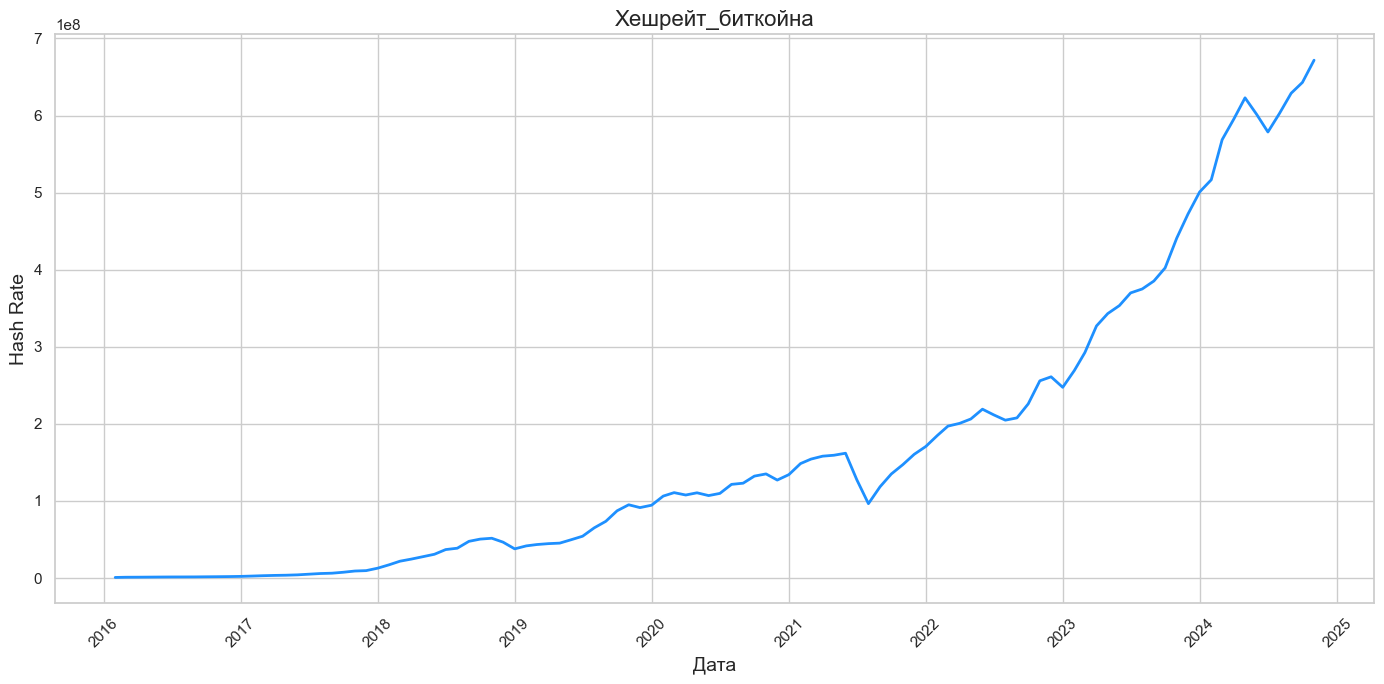

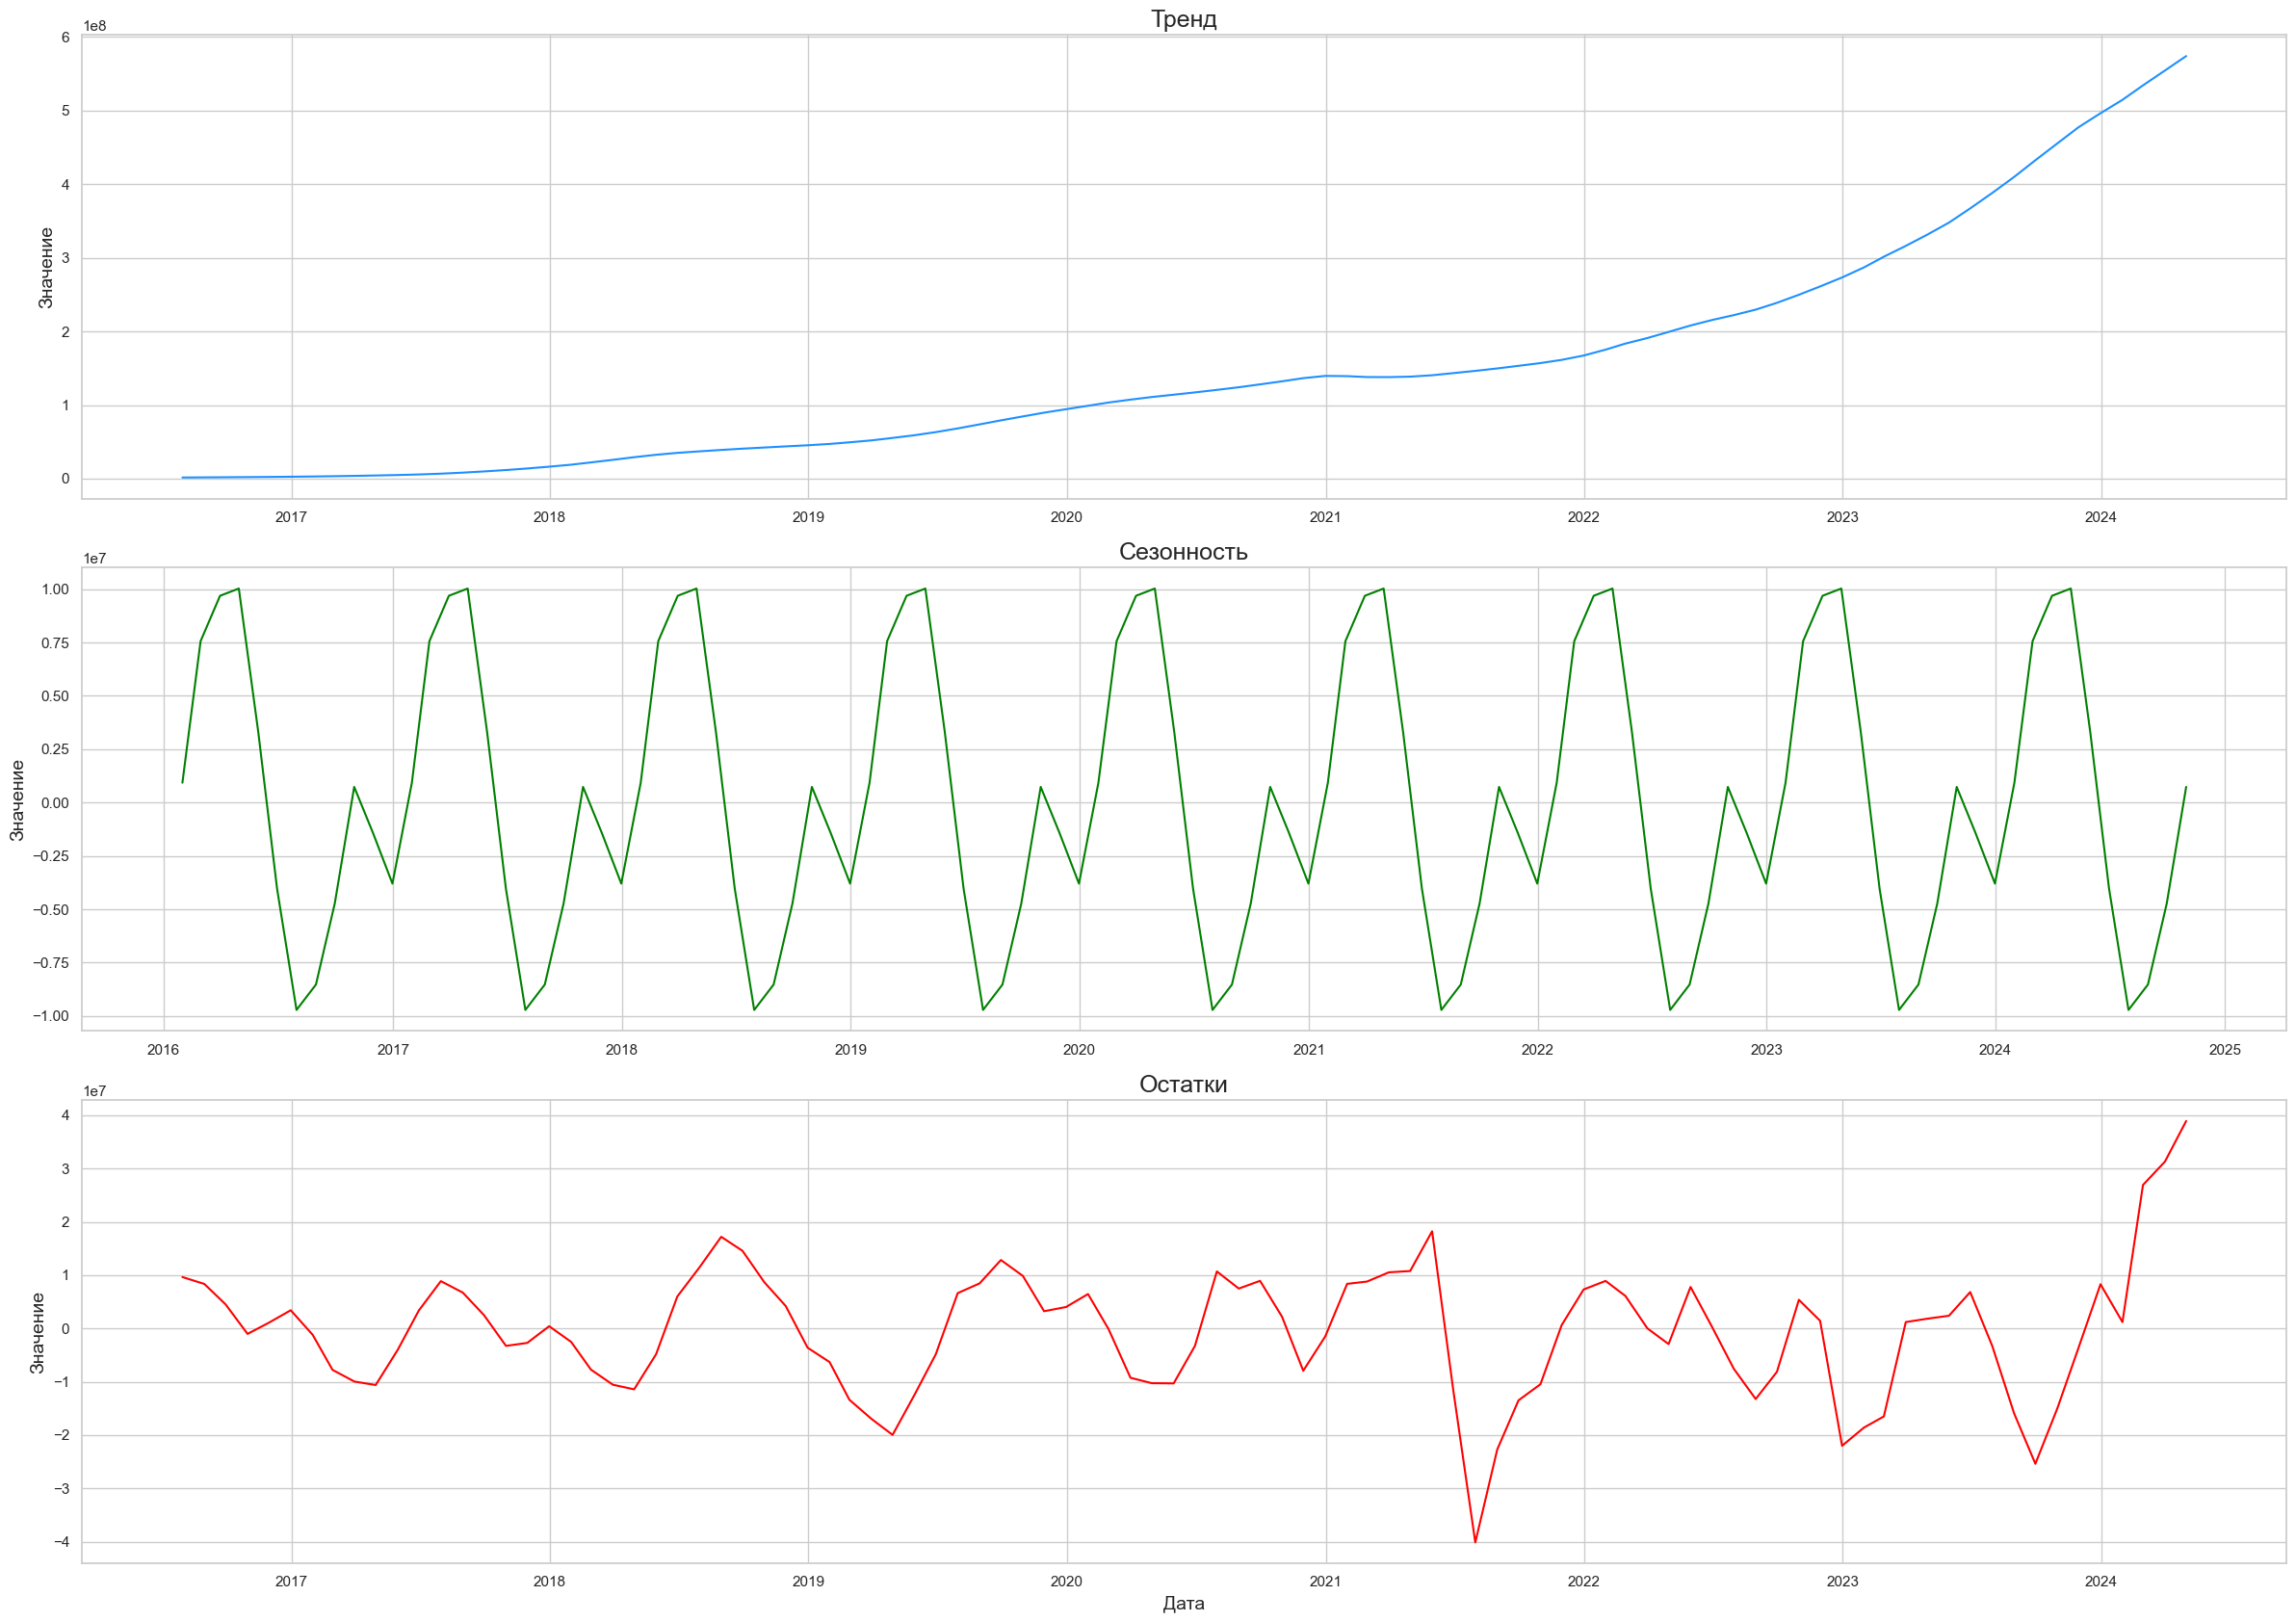

In [12]:
plot_time_series_and_decomposition(df_resampled, column='Hash_Rate',
                                   title='Хешрейт_биткойна', model='additive', 
                                   freq=12, resample_freq='1M')

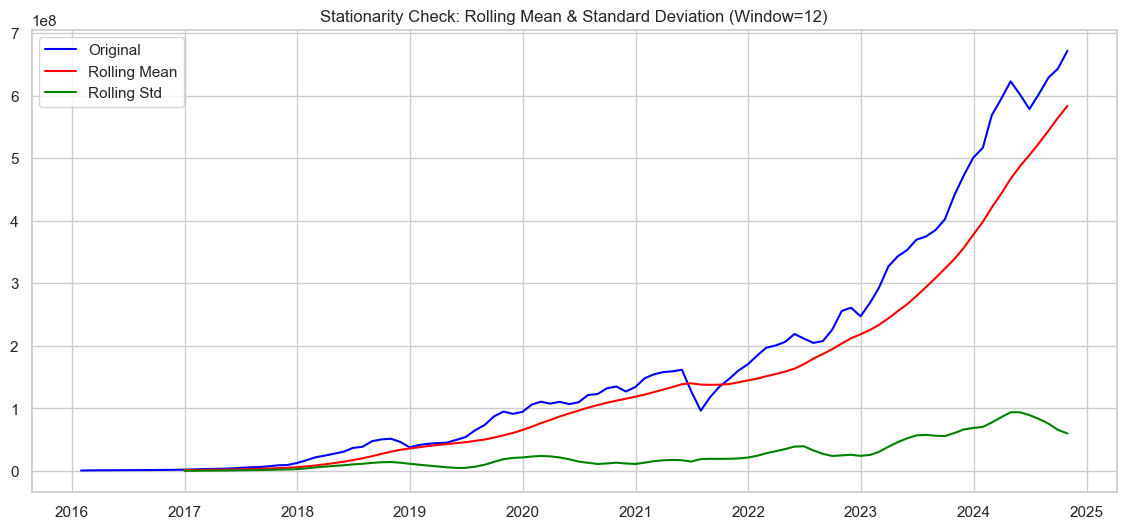


Описание распределения для скользящего среднего (окно=12):
count    9.500000e+01
mean     1.501419e+08
std      1.511738e+08
min      1.504239e+06
25%      3.502492e+07
50%      1.155220e+08
75%      2.080215e+08
max      5.836331e+08
Name: Hash_Rate, dtype: float64

Описание распределения для скользящего стандартного отклонения (окно=12):
count    9.500000e+01
mean     2.594506e+07
std      2.451282e+07
min      3.855942e+05
25%      9.669646e+06
50%      1.882654e+07
75%      3.233846e+07
max      9.397263e+07
Name: Hash_Rate, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                   3.790345
p-value                          1.000000
#Lags Used                       2.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64

Ряд не является стационарным (не отклоняем нулевую гипотезу).


In [13]:
check_stationarity(df_resampled, column='Hash_Rate', window=12)

__Выводы:__

- Наблюдается отсутствие постоянства среднего и стандартного отклонения
- Наблюдается возрастающий тренд
- Тест Дики Фулерра подтверждает, что ряд не станционарен
- Необходимо провести преобразования для введения станционарности

## Преобразования ряда для станционарности 

In [16]:
df = df_resampled.copy()  # Создаем явную копию

# Логарифмируем значения хешрейта
df['Log_Hash_Rate'] = np.log(df['Hash_Rate'])

# Удалим тренд
df['Diff_Log_Hash_Rate'] = df['Log_Hash_Rate'].diff()

# Удаляем строки с отсутствующими значениями
df = df.dropna()

In [17]:
df.head()

,Hash_Rate,Log_Hash_Rate,Diff_Log_Hash_Rate
Date,,,
2016-02-29,1.117381e+06,13.926498,0.288096
2016-03-31,1.178517e+06,13.979767,0.053270
2016-04-30,1.279960e+06,14.062339,0.082572
2016-05-31,1.389517e+06,14.144467,0.082127
2016-06-30,1.474838e+06,14.204059,0.059592


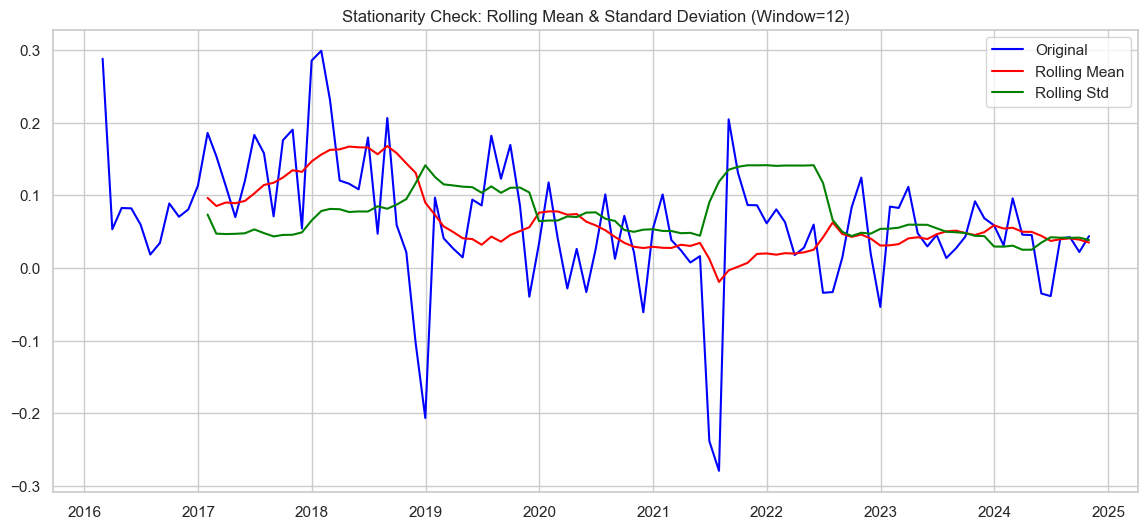


Описание распределения для скользящего среднего (окно=12):
count    94.000000
mean      0.063698
std       0.045533
min      -0.019203
25%       0.034559
50%       0.047462
75%       0.083475
max       0.167894
Name: Diff_Log_Hash_Rate, dtype: float64

Описание распределения для скользящего стандартного отклонения (окно=12):
count    94.000000
mean      0.074331
std       0.034418
min       0.025156
25%       0.047924
50%       0.064611
75%       0.103588
max       0.141535
Name: Diff_Log_Hash_Rate, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                -6.634970e+00
p-value                        5.592365e-09
#Lags Used                     0.000000e+00
Number of Observations Used    1.040000e+02
Critical Value (1%)           -3.494850e+00
Critical Value (5%)           -2.889758e+00
Critical Value (10%)          -2.581822e+00
dtype: float64

Ряд является стационарным (отклоняем нулевую гипотезу).


In [18]:
check_stationarity(df, column='Diff_Log_Hash_Rate', window=12)

## Подготовка лагов

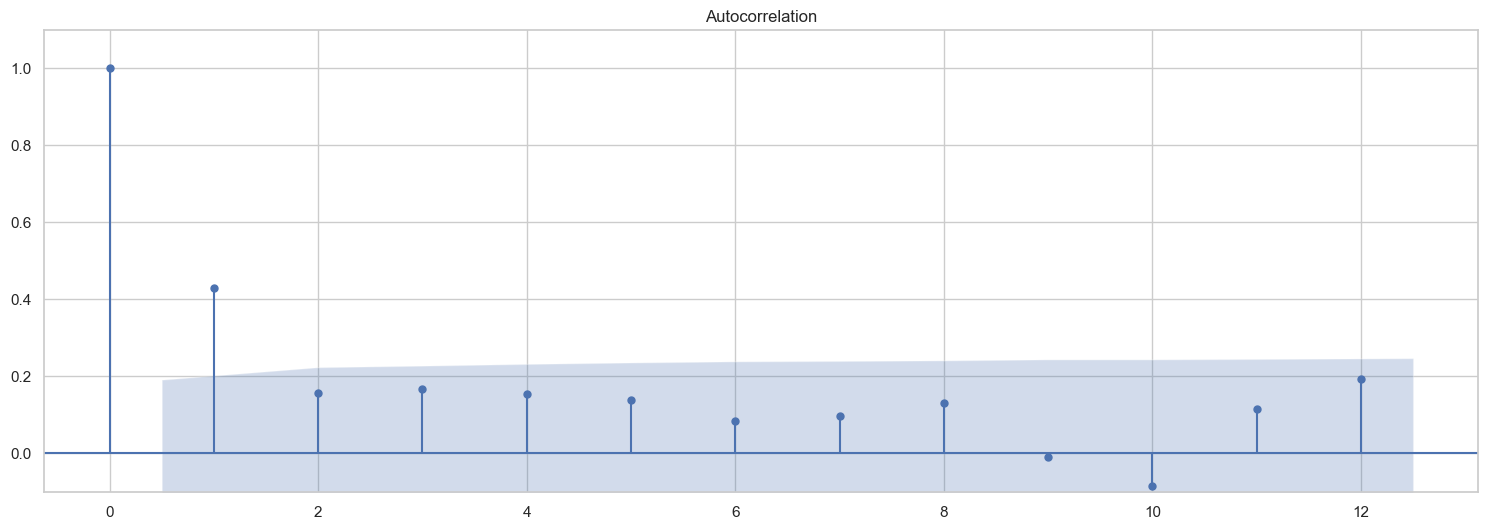

In [20]:
fig = tsaplots.plot_acf(df['Diff_Log_Hash_Rate'],lags= 12)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

In [21]:
def make_features(data, max_lag, max_window):
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['Diff_Log_Hash_Rate'].shift(lag)

    for rolling_window in range(1, max_window + 1):
        data['rolling_mean_{}'.format(rolling_window)] = data['Diff_Log_Hash_Rate'].shift().rolling(rolling_window).mean()

In [22]:
# Подбор значений аргументов функции make_features()
make_features(df, max_lag=12, max_window = 4)
df = df.dropna()

In [23]:
df.head()

,Hash_Rate,Log_Hash_Rate,Diff_Log_Hash_Rate,year,month,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean_1,rolling_mean_2,rolling_mean_3,rolling_mean_4
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-28,3.111051e+06,14.950471,0.153991,2017,2,0.185927,0.113430,0.080588,0.070552,0.088861,...,0.018542,0.059592,0.082127,0.082572,0.053270,0.288096,0.185927,0.149679,0.126648,0.112624
2017-03-31,3.479806e+06,15.062487,0.112016,2017,3,0.153991,0.185927,0.113430,0.080588,0.070552,...,0.034522,0.018542,0.059592,0.082127,0.082572,0.053270,0.153991,0.169959,0.151116,0.133484
2017-04-30,3.732426e+06,15.132569,0.070082,2017,4,0.112016,0.153991,0.185927,0.113430,0.080588,...,0.088861,0.034522,0.018542,0.059592,0.082127,0.082572,0.112016,0.133004,0.150645,0.141341
2017-05-31,4.209540e+06,15.252864,0.120295,2017,5,0.070082,0.112016,0.153991,0.185927,0.113430,...,0.070552,0.088861,0.034522,0.018542,0.059592,0.082127,0.070082,0.091049,0.112030,0.130504
2017-06-30,5.055713e+06,15.436029,0.183165,2017,6,0.120295,0.070082,0.112016,0.153991,0.185927,...,0.080588,0.070552,0.088861,0.034522,0.018542,0.059592,0.120295,0.095188,0.100798,0.114096


# Обучение модели

In [25]:
# Разделение данных на обучающую и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()

# Выделение признаков и целевого признака
features = ['year', 'month'] + [f'lag_{i}' for i in range(1, 8)] + [f'rolling_mean_{k}' for k in range(1,5)] 
target = 'Diff_Log_Hash_Rate'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [26]:
X_train.head()

,year,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean_1,rolling_mean_2,rolling_mean_3,rolling_mean_4
Date,,,,,,,,,,,,,
2017-02-28,2017,2,0.185927,0.113430,0.080588,0.070552,0.088861,0.034522,0.018542,0.185927,0.149679,0.126648,0.112624
2017-03-31,2017,3,0.153991,0.185927,0.113430,0.080588,0.070552,0.088861,0.034522,0.153991,0.169959,0.151116,0.133484
2017-04-30,2017,4,0.112016,0.153991,0.185927,0.113430,0.080588,0.070552,0.088861,0.112016,0.133004,0.150645,0.141341
2017-05-31,2017,5,0.070082,0.112016,0.153991,0.185927,0.113430,0.080588,0.070552,0.070082,0.091049,0.112030,0.130504
2017-06-30,2017,6,0.120295,0.070082,0.112016,0.153991,0.185927,0.113430,0.080588,0.120295,0.095188,0.100798,0.114096


In [27]:
#Пайплайн для подготовки данных 
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), features)
    ], 
    remainder='passthrough'
) 

In [28]:
#Итоговый пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

parameters = [
    # Словарь для модели LinearRegression
    {
        'models': [LinearRegression()],
        'preprocessor': [data_preprocessor]
    },
    # Словарь для модели LGBMRegressor
    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE, verbose=0)],
        'models__max_depth': [2,4,6,8,12],
        'preprocessor': [data_preprocessor]
    },
    # Словарь для модели XGBRegressor
    {
        'models': [XGBRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [2,4,6,8,12],
        'preprocessor': [data_preprocessor]
    },
    # Словарь для модели CatBoostRegressor
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)],
        'models__depth': [2,4,6,8,12],
        'preprocessor': [data_preprocessor]
    }
]

In [29]:
# Создаем пользовательскую метрику RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Используем эту метрику в качестве скоровочной функции
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

tscv = TimeSeriesSplit(n_splits=5)

randomized_search = RandomizedSearchCV(
    pipe_final, 
    parameters, 
    cv=tscv,
    scoring = rmse_scorer, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [30]:
randomized_search.fit(X_train, y_train)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there ar

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['year',
                                                                                'month',
                                                                                'lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'lag_7',
                                                                                'rolling_mean_1',
                                                                                'rolling_mean_2',
                                                                                'rolling_mean_3',
                                                                                'rolling_mean_...
                                         'preprocessor': [ColumnTransformer(remainder='passthrough',
                                                                            transformers=[('num',
                                                                                           StandardScaler(),
                                                                                           ['year',
                                                                                            'month',
                                                                                            'lag_1',
                                                                                            'lag_2',
                                                                                            'lag_3',
                                                                                            'lag_4',
                                                                                            'lag_5',
                                                                                            'lag_6',
                                                                                            'lag_7',
                                                                                            'rolling_mean_1',
                                                                                            'rolling_mean_2',
                                                                                            'rolling_mean_3',
                                                                                            'rolling_mean_4'])])]}],
                   random_state=42,
                   scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

In [31]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                                                   'rolling_mean_1',
                                                   'rolling_mean_2',
                                                   'rolling_mean_3',
                                                   'rolling_mean_4'])])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x15453f500>)])
Метрика лучшей модели на кросс-валидации: -0.09868687739752753


In [32]:
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').tail(10)) 

,rank_test_score,param_models,mean_test_score,params
9,1,<catboost.core.CatBoostRegressor object at 0x1544c9a30>,-0.098687,"{'preprocessor': ColumnTransformer(remainder='passthrough', transformers=[('num', StandardScaler(), ['year', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean_1', 'rolling_mean_2', 'rolling_mean_3', 'rolling_mean_4'])]), 'models__depth': 12, 'models': <catboost.core.CatBoostRegressor object at 0x1544c9a30>}"
4,2,<catboost.core.CatBoostRegressor object at 0x1544c9a30>,-0.099205,"{'preprocessor': ColumnTransformer(remainder='passthrough', transformers=[('num', StandardScaler(), ['year', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean_1', 'rolling_mean_2', 'rolling_mean_3', 'rolling_mean_4'])]), 'models__depth': 6, 'models': <catboost.core.CatBoostRegressor object at 0x1544c9a30>}"
7,3,"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=42, ...)",-0.099325,"{'preprocessor': ColumnTransformer(remainder='passthrough', transformers=[('num', StandardScaler(), ['year', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean_1', 'rolling_mean_2', 'rolling_mean_3', 'rolling_mean_4'])]), 'models__max_depth': 8, 'models': XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, random_state=42, ...)}"
3,4,<catboost.core.CatBoostRegressor object at 0x1544c9a30>,-0.099464,"{'preprocessor': ColumnTransformer(remainder='passthrough', transformers=[('num', StandardScaler(), ['year', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean_1', 'rolling_mean_2', 'rolling_mean_3', 'rolling_mean_4'])]), 'models__depth': 8, 'models': <catboost.core.CatBoostRegressor object at 0x1544c9a30>}"
6,5,"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=42, ...)",-0.100517,"{'preprocessor': ColumnTransformer(remainder='passthrough', transformers=[('num', StandardScaler(), ['year', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean_1', 'rolling_mean_2', 'rolling_mean_3', 'rolling_mean_4'])]), 'models__max_depth': 6, 'models': XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False

# Тестирование модели

Тестирование модели проходит на 20% исторических месячных данных прогноз на 1,5 года или в период с 2023-04 по 2024-10

In [34]:
# Прогнозы разностей логарифмированных значений
y_pred_diff_log = randomized_search.predict(X_test)

# Восстановление прогнозов в исходный масштаб через кумулятивную сумму
# Начинаем с последнего известного значения из обучающей выборки
y_pred_original = train['Hash_Rate'].iloc[-1] * np.exp(y_pred_diff_log.cumsum())

# Восстановление реальных значений для тестовой выборки
# Используем истинные разности, а не предсказанные
y_test_diff_log = y_test  # Это истинные разности
y_test_original = train['Hash_Rate'].iloc[-1] * np.exp(y_test_diff_log.cumsum())

# Вычисление RMSE на восстановленных значениях
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f'RMSE: {rmse}')

RMSE: 28952504.750075497


,Actual,Predicted
Date,,
2023-04-30,3.431148e+08,3.511651e+08
2023-05-31,3.534692e+08,3.672304e+08
2023-06-30,3.699255e+08,3.825289e+08
2023-07-31,3.750404e+08,3.963770e+08
2023-08-31,3.853479e+08,3.970547e+08
2023-09-30,4.023850e+08,4.130652e+08
2023-10-31,4.410675e+08,4.225416e+08
2023-11-30,4.722977e+08,4.422427e+08
2023-12-31,5.008642e+08,4.600279e+08


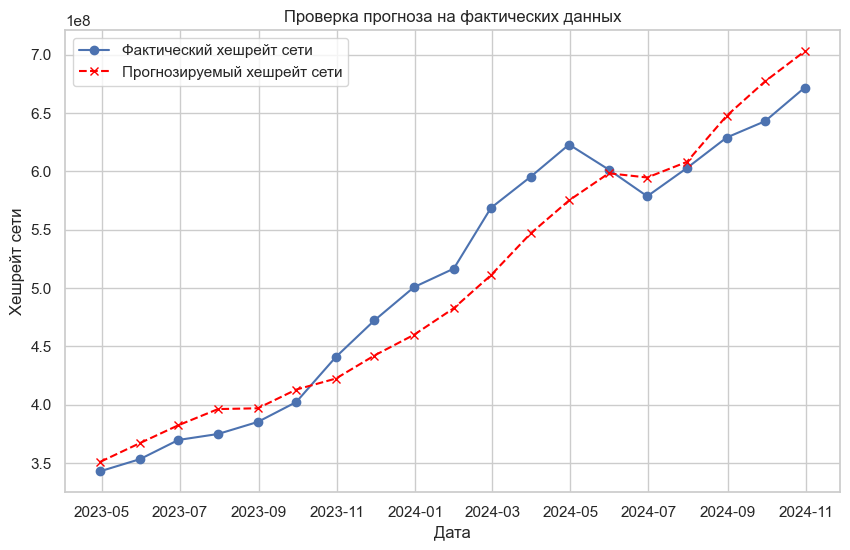

In [35]:
# Создание таблицы с восстановленными прогнозами и реальными значениями
results = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_pred_original
})

# Вывод таблицы
display(results)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(results['Actual'], label='Фактический хешрейт сети', marker='o')
plt.plot(results['Predicted'], label='Прогнозируемый хешрейт сети', marker='x', linestyle='--', color='red')
plt.title('Проверка прогноза на фактических данных')
plt.xlabel('Дата')
plt.ylabel('Хешрейт сети')
plt.legend()
plt.grid(True)
plt.show()